# Model Discrimination for  R32/emimTF2N system

EoS: PR vs. SRK

Parameter T dependence: Quadratic

N (total fitting parameters): 6

## Import Functions


In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

import scipy.stats as stats

## Make model functions

In [2]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
def calc_PRmod_P(x_HFC,T):
    '''
    Define function to calculate the PR 4 parameter model pressure given a composition and temperature
    
    Inputs:
    x_HFC - HFC compositions
    T - temperature to run
    
    Output: 
    P: pressure
    
    '''
    
    m = ConcreteModel()

    m.fs = FlowsheetBlock(default={"dynamic": False})
    
    # Configuration
    from hfc32_emimtf2n_PR import configuration as config_PR

    m.fs.properties = GenericParameterBlock(default=config_PR)

    m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

    m.fs.F101.inlet.flow_mol.fix(1)
    m.fs.F101.inlet.temperature.fix(323.15)
    m.fs.F101.inlet.pressure.fix(399800)
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)
    
    # Model params
    params_PR = pd.read_csv('../Params/PR_params_linTdep.csv',header=None)
    
    m.fs.properties.PR_kappa_A['R32','emimTf2N'] = float(params_PR.iloc[0])
    m.fs.properties.PR_kappa_A['emimTf2N','R32'] = float(params_PR.iloc[1])
    m.fs.properties.PR_kappa_B['R32','emimTf2N'] = float(params_PR.iloc[2])
    m.fs.properties.PR_kappa_B['emimTf2N','R32'] = float(params_PR.iloc[3])
    m.fs.properties.PR_kappa_C['R32','emimTf2N'] = float(params_PR.iloc[4])
    m.fs.properties.PR_kappa_C['emimTf2N','R32'] = float(params_PR.iloc[5])
    
    # Initialize the flash unit
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

    # Fix the state variables on the state block
    # m.fs.F101.inlet.pressure.unfix()
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)
    
    # Calc pressure
    x_IL = 1-x_HFC
    if 0.05 <= x_HFC <= 0.09:
        guess_P = 90000
    elif 0.09 < x_HFC <= 0.15:
        guess_P = 100100
    elif 0.15 < x_HFC <= 3:
        guess_P = 250000
    else:
        guess_P = 400000
    
    m.fs.liq = x_IL
    m.fs.F101.inlet.temperature.fix(T)
    m.fs.F101.inlet.pressure.fix(guess_P)
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(x_HFC+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(x_HFC+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(T))
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        
    except:
        print('Initialization Error')
        
    try:

        status = solver.solve(m, tee = False)
        
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print('Feasible/Optimal Solution')
            x_HFC_final = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P_final = value(m.fs.F101.vap_outlet.pressure[0])
        else:
            print('Infeasible Solution')
            x_HFC_final = np.nan
            P_final = np.nan
            
    except ValueError:
        x_HFC_final = np.nan
        P_final = np.nan
        print('Solver Error')
    
    return P_final

In [4]:
def calc_SRKmod_P(x_HFC,T):
    '''
    Define function to calculate the SRK 4 parameter model pressure given a composition and temperature
    
    Inputs:
    x_HFC - HFC compositions
    T - temperature to run
    
    Output: 
    P: pressure
    
    '''
    
    m = ConcreteModel()

    m.fs = FlowsheetBlock(default={"dynamic": False})
    
    # Configuration
    from hfc32_emimtf2n_SRK import configuration as config_SRK

    m.fs.properties = GenericParameterBlock(default=config_SRK)

    m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

    m.fs.F101.inlet.flow_mol.fix(1)
    m.fs.F101.inlet.temperature.fix(323.15)
    m.fs.F101.inlet.pressure.fix(399800)
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)
    
    # Model params
    params_SRK = pd.read_csv('../Params/SRK_params_linTdep.csv',header=None)
    
    m.fs.properties.SRK_kappa_A['R32','emimTf2N'] = float(params_SRK.iloc[0])
    m.fs.properties.SRK_kappa_A['emimTf2N','R32'] = float(params_SRK.iloc[1])
    m.fs.properties.SRK_kappa_B['R32','emimTf2N'] = float(params_SRK.iloc[2])
    m.fs.properties.SRK_kappa_B['emimTf2N','R32'] = float(params_SRK.iloc[3])
    m.fs.properties.SRK_kappa_C['R32','emimTf2N'] = float(params_SRK.iloc[4])
    m.fs.properties.SRK_kappa_C['emimTf2N','R32'] = float(params_SRK.iloc[5])
    
    # Initialize the flash unit
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

    # Fix the state variables on the state block
    # m.fs.F101.inlet.pressure.unfix()
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)
    
    # Calc pressure
    x_IL = 1-x_HFC
    if 0.05 <= x_HFC <= 0.09:
        guess_P = 90000
    elif 0.09 < x_HFC <= 0.15:
        guess_P = 100100
    elif 0.15 < x_HFC <= 3:
        guess_P = 250000
    else:
        guess_P = 400000
    
    
    m.fs.liq = x_IL
    m.fs.F101.inlet.temperature.fix(T)
    m.fs.F101.inlet.pressure.fix(guess_P)
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(x_HFC+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(x_HFC+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(T))
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        
    except:
        print('Initialization Error')
        
    try:

        status = solver.solve(m, tee = False)
        
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print('Feasible/Optimal Solution')
            x_HFC_final = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P_final = value(m.fs.F101.vap_outlet.pressure[0])
        else:
            print('Infeasible Solution')
            x_HFC_final = np.nan
            P_final = np.nan
            
    except ValueError:
        x_HFC_final = np.nan
        P_final = np.nan
        print('Solver Error')
    
    return P_final

In [5]:
def error(params):
    '''
    Function which calculates the squared error between two models
 
    Inputs:
    params:
        x_HFC - HFC compositions
        T - temperature to run
    
    Ouputs:
    error - squared error between two models, made negative
    '''
    
    x_HFC = params[0]
    T = params[1]
    
    print('Trying x_HFC:',x_HFC)
    print('Trying T:',T)
    
    P_PR = calc_PRmod_P(x_HFC,T)
    
    P_SRK = calc_SRKmod_P(x_HFC,T)
    
    error = (P_PR - P_SRK)**2
    
    print('error:',error)
    
    return error*(-1)

## Setup Optimization Problem for Model Discrimination

In [6]:
# Correct Bounds, Initial Point
var_guess = (0.7,270)
bnds = ((0.15,0.9),(273,400))
results = scipy.optimize.minimize(error,var_guess,bounds=bnds)#,tol=1E-4)

Trying x_HFC: 0.7
Trying T: 273.0
Feasible/Optimal Solution
Feasible/Optimal Solution
error: 1825038.9364393053
Trying x_HFC: 0.70000001
Trying T: 273.0
Feasible/Optimal Solution
Feasible/Optimal Solution
error: 1825038.9547033985
Trying x_HFC: 0.7
Trying T: 273.00000001
Feasible/Optimal Solution
Feasible/Optimal Solution
error: 1825038.9336611286
Trying x_HFC: 0.9
Trying T: 273.0
Feasible/Optimal Solution
Feasible/Optimal Solution
error: 969662.9010447433
Trying x_HFC: 0.89999999
Trying T: 273.0
Feasible/Optimal Solution
Feasible/Optimal Solution
error: 969662.1293024605
Trying x_HFC: 0.9
Trying T: 273.00000001
Feasible/Optimal Solution
Feasible/Optimal Solution
error: 969662.9058617426
Trying x_HFC: 0.7019775079082394
Trying T: 273.0
Feasible/Optimal Solution
Feasible/Optimal Solution
error: 1828052.667179176
Trying x_HFC: 0.7019775179082395
Trying T: 273.0
Feasible/Optimal Solution
Feasible/Optimal Solution
error: 1828052.6832286157
Trying x_HFC: 0.7019775079082394
Trying T: 273.000

In [7]:
results

      fun: -1835959.9115564784
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-44514.21532764, -32936.08030832])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 5
     njev: 12
   status: 0
  success: True
        x: array([  0.71293428, 273.        ])

In [13]:
results.x[0]

0.7129342788568918

In [11]:
P_PR = calc_PRmod_P(0.71293428,273)
print('PR Prediction:',P_PR)

P_SRK = calc_SRKmod_P(0.71293428,273)
print('SRK Prediction:',P_SRK)

Feasible/Optimal Solution
PR Prediction: 526003.0526461601
Feasible/Optimal Solution
SRK Prediction: 524648.0766645058


In [8]:
data_subset = pd.read_csv('../r32_emimtf2n_subset.csv')

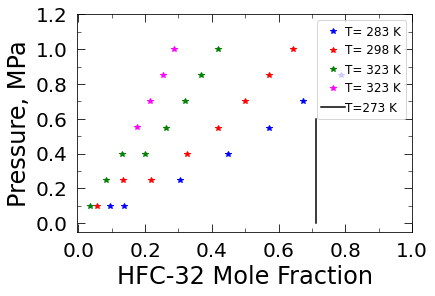

In [23]:
fig, ax = plt.subplots()

ax.plot(data_subset["x_R32"][:7],data_subset["pressure"][:7]/1e6,"*",color='blue',label="T= 283 K")
ax.plot(data_subset["x_R32"][7:15],data_subset["pressure"][7:15]/1e6,"*",color='red',label="T= 298 K")
ax.plot(data_subset["x_R32"][15:23],data_subset["pressure"][15:23]/1e6,"*",color='green',label="T= 323 K")
ax.plot(data_subset["x_R32"][23:],data_subset["pressure"][23:]/1e6,"*",color='magenta',label="T= 323 K")

new_x = [results.x[0],results.x[0]]
new_y = [0,0.6]

ax.plot(new_x,new_y,"-",color='black',label="T=273 K")

# plt.title('Isotherm R32-[emim][TF2N]')
ax.set_ylabel('Pressure, MPa',fontsize=24)
ax.set_xlabel('HFC-32 Mole Fraction',fontsize=24)

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9],minor=True)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1],minor=True)

ax.tick_params("both", direction="in", which="both", length=4, labelsize=20, pad=10)
ax.tick_params("both", which="major", length=8)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(fontsize=12, handletextpad=0.00, loc="upper right")#, bbox_to_anchor=(1, 0.5))
fig.savefig('R32-emimTF2N-data-disc.pdf',bbox_inches='tight')
plt.show()